### Helpers

In [41]:
import os
from dotenv import load_dotenv

load_dotenv() 
api_key = os.environ['TOGETHER_API_API_KEY']

In [42]:
import warnings
import requests
import json
import time
from dotenv import find_dotenv

_ = load_dotenv(find_dotenv())
url = f"https://api.together.xyz/inference"
headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

def llama(prompt, 
          add_inst=True, 
          model="togethercomputer/llama-2-70b-chat", 
          temperature=0.0, 
          max_tokens=1024,
          verbose=False,
          url=url,
          headers=headers,
          base=2, # number of seconds to wait
          max_tries=3):
    
    if add_inst:
        prompt = f"[INST]{prompt}[/INST]"

    if verbose:
        print(f"Prompt:\n{prompt}\n")
        print(f"model: {model}")

    data = {
            "model": model,
            "prompt": prompt,
            "temperature": temperature,
            "max_tokens": max_tokens
        }

    # Allow multiple attempts to call the API incase of downtime.
    # Return provided response to user after 3 failed attempts.
    wait_seconds = [base**i for i in range(max_tries)]

    for num_tries in range(max_tries):
        try:
            response = requests.post(url, headers=headers, json=data)
            return response.json()['output']['choices'][0]['text']
        except Exception as e:
            if response.status_code != 500:
                return response.json()

            print(f"error message: {e}")
            print(f"response object: {response}")
            print(f"num_tries {num_tries}")
            print(f"Waiting {wait_seconds[num_tries]} seconds before automatically trying again.")
            time.sleep(wait_seconds[num_tries])
 
    print(f"Tried {max_tries} times to make API call to get a valid response object")
    print("Returning provided response")
    return response


def llama_chat(prompts, 
               responses,
               model="togethercomputer/llama-2-7b-chat", 
               temperature=0.0, 
               max_tokens=1024,
               verbose=False,
               url=url,
               headers=headers,
               base=2,
               max_tries=3
              ):

    prompt = get_prompt_chat(prompts,responses)

    # Allow multiple attempts to call the API incase of downtime.
    # Return provided response to user after 3 failed attempts.
    wait_seconds = [base**i for i in range(max_tries)]

    for num_tries in range(max_tries):
        try:
            response = llama(prompt=prompt,
                             add_inst=False,
                             model=model, 
                             temperature=temperature, 
                             max_tokens=max_tokens,
                             verbose=verbose,
                             url=url,
                             headers=headers
                            )
            return response
        except Exception as e:
            if response.status_code != 500:
                return response.json()

            print(f"error message: {e}")
            print(f"response object: {response}")
            print(f"num_tries {num_tries}")
            print(f"Waiting {wait_seconds[num_tries]} seconds before automatically trying again.")
            time.sleep(wait_seconds[num_tries])
 
    print(f"Tried {max_tries} times to make API call to get a valid response object")
    print("Returning provided response")
    return response


def get_prompt_chat(prompts, responses):
  prompt_chat = f"<s>[INST] {prompts[0]} [/INST]"
  for n, response in enumerate(prompts):
    prompt = prompts[n + 1]
    prompt_chat += f"\n{response}\n </s><s>[INST] \n{ prompt }\n [/INST]"

  return prompt_chat

In [43]:
import spacy
nlp = spacy.load("en_core_web_md")

def get_cleaned_text(text):
    tok_list = []
    for token in nlp(text):
        tok_list.append(str(token))
    return ' '.join(tok_list)

### Data Preparation

In [44]:
with open("../data/cbp-lkg/data/SIMILARITY/MAPPING.json") as f:
    mapping = json.loads(f.read())

dict_mapping = {f'{mapping[k]}':k for k in mapping}

In [45]:
with open("../data/cbp-lkg/data/SIMILARITY/similarity_demo_file.json") as f:
    similarity_data = json.loads(f.read())

In [46]:
similarity_pairs = similarity_data[0]['links_train']
similarity_pairs[:5]

[['798', '719'],
 ['799', '670'],
 ['800', '840'],
 ['801', '840'],
 ['802', '176']]

In [47]:
doc_pairs = []

for pair in similarity_pairs:
    [_s, _o] = pair
    s = dict_mapping[_s]
    o = dict_mapping[_o]
    doc_pairs.append((s, o))

doc_pairs[:5]

[('1206754', '795465'),
 ('51545606', '997135'),
 ('1735815', '1857950'),
 ('383397', '1857950'),
 ('60799', '1844910')]

In [48]:
import glob
import random
from itertools import combinations

cases = list(set(mapping.keys()))
all_pairs = list(combinations(cases, 2))
all_pairs[:5]

[('334293', '386457'),
 ('334293', '279466'),
 ('334293', '151609698'),
 ('334293', '19267666'),
 ('334293', '179794777')]

In [49]:
set_diff = set(all_pairs) - set(doc_pairs)

In [50]:
import random

random.seed(42)
random_pairs = random.sample(list(set_diff), len(doc_pairs))

random_pairs[:5]

[('992249', '130353321'),
 ('1326449', '850428'),
 ('1969682', '507033'),
 ('1114158', '1961394'),
 ('627069', '525017')]

In [11]:
with open("../results/case-similarity-data-for-llms-with-acts.csv", "w") as f:
    f.write("doc1,doc2,similarity\n")
    for i in doc_pairs:
        f.write(f"{i[0]}, {i[1]}, 1\n")
    for i in random_pairs:
        f.write(f"{i[0]}, {i[1]}, 0\n")

In [12]:
del all_pairs
del set_diff

In [51]:
import pandas as pd

df = pd.read_csv("../data/case-similarity/case-similarity-data-for-llms.csv").sample(frac=1).reset_index(drop=True)
df

,doc1,doc2,similarity
0,743158,1134697,0
1,614536,161147300,1
2,161614515,861349,1
3,1965879,514933,1
4,155329262,1668065,1
...,...,...,...
2621,350976,127517806,0
2622,165776436,576454,1
2623,1822024,1001948,0
2624,138184,67892682,0


In [52]:
df.groupby('similarity').head(2)

,doc1,doc2,similarity
0,743158,1134697,0
1,614536,161147300,1
2,161614515,861349,1
6,1902038,588099,0


In [53]:
doc_set = set(df['doc1'].to_list() + df['doc2'].to_list())
len(doc_set)

958

In [ ]:
import shutil

for case_number in list(doc_set):
    source_file_path = os.path.join(os.getcwd(), f"../data/cbp-lkg/data/LEGAL_TEXT/{case_number}.txt")
    destination_file_path = os.path.join(os.getcwd(), f"../results/case-similarity-text/raw/{case_number}.txt")
    shutil.copy(source_file_path, destination_file_path)

### Data Extraction

In [18]:
%%writefile ../legal-text-extract-tail.sh

#!/bin/bash

source_dir="../data/cbp-lkg/data/LEGAL_TEXT/"
destination_dir="../results/case-similarity-text/cut"

mkdir -p "$destination_dir"

for file in "$source_dir"/*.txt; do
    filename=$(basename -- "$file")
    destination_path="$destination_dir/$filename"
    if [ "$(wc -l < "$source_dir$filename")" -gt 30 ]; then
      cat "$file" | ag "\S" | tail -n 20 | head -n -5 > "$destination_path"
    else
      cat "$file" | ag "\S" | tail -n 20 > "$destination_path"
    fi
    echo "Wrote $destination_path ..."
done

Overwriting ../legal-text-extract-tail.sh


In [19]:
!chmod +x ../legal-text-extract-tail.sh
!../legal-text-extract-tail.sh | tail

Wrote ../results/case-similarity-text/cut/994554.txt ...
Wrote ../results/case-similarity-text/cut/994832.txt ...
Wrote ../results/case-similarity-text/cut/995861.txt ...
Wrote ../results/case-similarity-text/cut/99610538.txt ...
Wrote ../results/case-similarity-text/cut/99622088.txt ...
Wrote ../results/case-similarity-text/cut/996328.txt ...
Wrote ../results/case-similarity-text/cut/996348.txt ...
Wrote ../results/case-similarity-text/cut/99670896.txt ...
Wrote ../results/case-similarity-text/cut/997135.txt ...
Wrote ../results/case-similarity-text/cut/999236.txt ...


In [20]:
!ls -l ../results/case-similarity-text/cut | wc -l

2287


### Prompting LLaMA-2

##### Top-$k$ Sampling

In [55]:
sample_df = df.groupby('similarity').tail(10).groupby('similarity').head(2).sample(frac=1).reset_index(drop=True)
sample_df

,doc1,doc2,similarity
0,383397,1377335,1
1,70487596,23954109,0
2,181654439,1318646,0
3,1001948,474885,1


##### Prompt Preparation

In [60]:
def get_text(filename):
    with open(f"../data/case-similarity/case-similarity-text/cut/{filename}.txt") as f:
        return f.read()

In [61]:
print(get_text(51545606))

Delhi. We cannot order transfer of suit in these proceedings. In case parties
so desire, they are free to file appropriate application but the suit is
required to be presented in the court of competent jurisdiction only
thereafter the question of transfer would be germane.
47\. In our opinion, the provisions of section 62 of the Copyright Act and
section 134 of the Trade Marks Act have to be interpreted in the purposive
manner. No doubt about it that a suit can be filed by the plaintiff at a place
where he is residing or carrying on business or personally works for gain. He
need not travel to file a suit to a place where defendant is residing or cause
of action wholly or in part arises. However, if the plaintiff is residing or
carrying on business etc. at a place where cause of action, wholly or in part,
has also arisen, he has to file a suit at that place, as discussed above.
Thus, for the aforesaid reasons mentioned by us in the judgment, we are not
inclined to interfere with the ord

In [62]:
def get_similarity(sim, mask):
    if mask:
        return '?'
    elif sim == 1:
        return 'Yes'
    return 'No'

def get_example(idx, row, mask_similarity=False):
    doc1 = get_text(row['doc1'])
    doc2 = get_text(row['doc2'])
    similarity = row['similarity']

    return f"""### Document {idx}: {doc1}
### Document {idx + 1}: {doc2}
### Similarity: {get_similarity(similarity, mask_similarity)}

"""

In [63]:
for idx, row in sample_df.iterrows():
    print(row)
    break

doc1           383397
doc2          1377335
similarity          1
Name: 0, dtype: int64


In [64]:
prompt_text = 'Given below are four pairs of legal documents. You have been presented with some parts of these documents and whether they are similar or not. Try to answer for Document 9 and Document 10.\n\n'

for idx, row in sample_df.iterrows():
    example = get_example(2*idx + 1, row)
    prompt_text += example

In [65]:
print(prompt_text)

Given below are four pairs of legal documents. You have been presented with some parts of these documents and whether they are similar or not. Try to answer for Document 9 and Document 10.

### Document 1: provided to the Copyright Board against the order of the Registrar under
Sec.72 of the Copyright Act. We mention the character of the order under Sec.
53 to indicate that the effect of an order under of the Copyright Act is not
as portentous as a notification under Sec. 11 of the Customs Act. The
Registrar is nor bound to make an order under Sec. 53 of the Copyright Act so
soon as an application is presented to him by the owner of the Copyright. He
has naturally to consider the context of the mischief sought to be prevented.
He must consider whether the copies would infringe the Copyright if the copies
were made in India. He must consider whether the applicant owns the Copyright
or is the duly authorised agent of the Copyright. He must hear these claiming
to be affected if an order i

##### Example Run

In [66]:
df.head(1)

,doc1,doc2,similarity
0,743158,1134697,0


In [67]:
for idx, doc in df.head(1).iterrows():
    test_example = get_example(9, doc, mask_similarity=True)
    
print(test_example)

### Document 9: appropriate authority and kept on its file without communicating it to the
officer concerned or otherwise publishing it will take effect as from the date
on which the order is actually written out by the said authority; such an
order can only be effective after it is communicated to the officer concerned
or is otherwise published. When a public officer is removed from service, his
successor would have to take charge of the said office; and except in cases
where the officer concerned has already been suspended, difficulties would
arise if it is held that an officer who is actually working and holding charge
of his office, can be said to be effectively removed from his office by the
mere passing of an order by the appropriate authority. In our opinion,
therefore, the High Court was plainly right in holding that the order of
dismissal passed against the respondent on the 3rd June 1949 could not be said
to have taken effect until the respondent came to know about it on the 

In [68]:
prompt = f"""{prompt_text}{test_example}Similarly, are the given parts of Legal Document 9 and Legal Document 10 similar? Give a one word response: Yes or No."""
print(prompt)

Given below are four pairs of legal documents. You have been presented with some parts of these documents and whether they are similar or not. Try to answer for Document 9 and Document 10.

### Document 1: provided to the Copyright Board against the order of the Registrar under
Sec.72 of the Copyright Act. We mention the character of the order under Sec.
53 to indicate that the effect of an order under of the Copyright Act is not
as portentous as a notification under Sec. 11 of the Customs Act. The
Registrar is nor bound to make an order under Sec. 53 of the Copyright Act so
soon as an application is presented to him by the owner of the Copyright. He
has naturally to consider the context of the mischief sought to be prevented.
He must consider whether the copies would infringe the Copyright if the copies
were made in India. He must consider whether the applicant owns the Copyright
or is the duly authorised agent of the Copyright. He must hear these claiming
to be affected if an order i

In [69]:
response = llama(prompt, verbose=True, max_tokens=180)

Prompt:
[INST]Given below are four pairs of legal documents. You have been presented with some parts of these documents and whether they are similar or not. Try to answer for Document 9 and Document 10.

### Document 1: provided to the Copyright Board against the order of the Registrar under
Sec.72 of the Copyright Act. We mention the character of the order under Sec.
53 to indicate that the effect of an order under of the Copyright Act is not
as portentous as a notification under Sec. 11 of the Customs Act. The
Registrar is nor bound to make an order under Sec. 53 of the Copyright Act so
soon as an application is presented to him by the owner of the Copyright. He
has naturally to consider the context of the mischief sought to be prevented.
He must consider whether the copies would infringe the Copyright if the copies
were made in India. He must consider whether the applicant owns the Copyright
or is the duly authorised agent of the Copyright. He must hear these claiming
to be affected

In [70]:
print(response.strip())

Yes.

The given parts of Legal Document 9 and Legal Document 10 are similar in that they both discuss the effectiveness of an order or decision and the importance of communication or publication in making such an order or decision valid. Both documents also cite previous court cases to support their arguments. Therefore, the similarity between the two documents is Yes.


##### Negative Example

In [71]:
for idx, doc in df.tail(3).tail(1).iterrows():
    print(doc)
    test_example = get_example(9, doc, mask_similarity=True)
    
print(test_example)

doc1          103561
doc2          858066
similarity         1
Name: 2625, dtype: int64
### Document 9: as the registered user of the 341 said trade mark is still pending and when
the Central Government comes to consider that application, it will decide the
matter for itself. After all, the best guardian of the policy of the Central
Government is the Central Government itself and not a private limited company,
namely, Mac Laboratories Private Limited, the First Respondent before us,
which has a vital interest in having the trade mark 'DRISTAN' removed from the
Register.
For the reasons given above, this Appeal must succeed and is allowed and the
judgment of the Division Bench of the Calcutta High court appealed against is
reversed and the order passed by it is set aside. Consequently, Appeal No. 165
of 1968 filed by the Appellant before the Division Bench of the Calcutta High
Court is allowed with costs and the judgment of the learned Single Judge of
that High Court and the order passe

In [72]:
prompt = f"""{prompt_text}{test_example}Similarly, are the given parts of Legal Document 9 and Legal Document 10 similar apart from the fact that they contain discussions of legal terms? Give a one word response: Yes or No."""
response = llama(prompt, verbose=True, max_tokens=180)

Prompt:
[INST]Given below are four pairs of legal documents. You have been presented with some parts of these documents and whether they are similar or not. Try to answer for Document 9 and Document 10.

### Document 1: provided to the Copyright Board against the order of the Registrar under
Sec.72 of the Copyright Act. We mention the character of the order under Sec.
53 to indicate that the effect of an order under of the Copyright Act is not
as portentous as a notification under Sec. 11 of the Customs Act. The
Registrar is nor bound to make an order under Sec. 53 of the Copyright Act so
soon as an application is presented to him by the owner of the Copyright. He
has naturally to consider the context of the mischief sought to be prevented.
He must consider whether the copies would infringe the Copyright if the copies
were made in India. He must consider whether the applicant owns the Copyright
or is the duly authorised agent of the Copyright. He must hear these claiming
to be affected

In [73]:
print(response.strip())

No.

The given parts of Legal Document 9 and Legal Document 10 are not similar. Legal Document 9 appears to be a judgment or order from a court case, while Legal Document 10 seems to be a legal agreement or contract between two parties. The language and structure of the two documents are different, and they do not share any common elements or concepts. Therefore, the similarity between the two documents is low.


##### The Experiment

In [159]:
from tqdm.notebook import tqdm 
from time import sleep

# prompts_df = []
# responses_df = []
# actuals_df = []

# sample_master = df.sample(frac=1).reset_index(drop=True)

for idx, row in tqdm(sample_master.iloc[2203:,:].iterrows(), total=sample_master.iloc[2203:,:].shape[0]):    
# for idx, row in tqdm(sample_master.iterrows(), total=sample_master.shape[0]):    
    test_example = get_example(9, row, mask_similarity=True)
    prompt = f"""{prompt_text}{test_example}Similarly, are the given parts of Legal Document 9 and Legal Document 10 similar apart from the fact that they contain discussions of legal terms? Give a one word response: Yes or No."""
    response = llama(prompt, max_tokens=50, base=10, max_tries=100)
    try:
        responses_df.append(response.strip())
        prompts_df.append(f'[INST]{prompt}[/INST]')
        actuals_df.append(row['similarity'])
    except:
        print(row)
        print(response)
    # sleep(1)

  0%|          | 0/423 [00:00<?, ?it/s]

In [160]:
predictions = pd.DataFrame({
    'prompt': prompts_df,
    'response': responses_df,
    'actual': actuals_df
})

predictions

,prompt,response,actual
0,[INST]Given below are four pairs of legal docu...,Yes.\n\nThe given parts of Legal Document 9 an...,1
1,[INST]Given below are four pairs of legal docu...,Yes.\n\nThe given parts of Legal Document 9 an...,1
2,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,0
3,[INST]Given below are four pairs of legal docu...,Yes.\n\nThe given parts of Legal Document 9 an...,1
4,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,0
...,...,...,...
2621,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,0
2622,[INST]Given below are four pairs of legal docu...,Yes.\n\nThe given parts of Legal Document 9 an...,0
2623,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,1
2624,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,0


In [161]:
predictions['pred'] = predictions['response'].apply(lambda x: 1 if 'Yes' in x.split('\n')[0] else 0)

In [162]:
predictions

,prompt,response,actual,pred
0,[INST]Given below are four pairs of legal docu...,Yes.\n\nThe given parts of Legal Document 9 an...,1,1
1,[INST]Given below are four pairs of legal docu...,Yes.\n\nThe given parts of Legal Document 9 an...,1,1
2,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,0,0
3,[INST]Given below are four pairs of legal docu...,Yes.\n\nThe given parts of Legal Document 9 an...,1,1
4,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,0,0
...,...,...,...,...
2621,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,0,0
2622,[INST]Given below are four pairs of legal docu...,Yes.\n\nThe given parts of Legal Document 9 an...,0,1
2623,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,1,0
2624,[INST]Given below are four pairs of legal docu...,No.\n\nThe given parts of Legal Document 9 and...,0,0


In [163]:
from sklearn.metrics import classification_report

print(classification_report(predictions['actual'], predictions['pred'], digits=4))

              precision    recall  f1-score   support

           0     0.5830    0.4653    0.5176      1313
           1     0.5551    0.6672    0.6060      1313

    accuracy                         0.5663      2626
   macro avg     0.5691    0.5663    0.5618      2626
weighted avg     0.5691    0.5663    0.5618      2626



In [165]:
predictions['doc1'] = sample_master['doc1']
predictions['doc2'] = sample_master['doc2']

In [166]:
predictions.to_csv('../data/case-similarity/case-similarity-responses-llama2-70b-chat.csv', index=False)

In [168]:
predictions['response'].apply(lambda x: x.split('\n')[0]).unique()

array(['Yes.', 'No.', 'Similarity: No.',
       'Similarity between Document 9 and Document 10: No.',
       'Similarity: No', 'Similarity: Yes', 'Similarity: Yes.'],
      dtype=object)

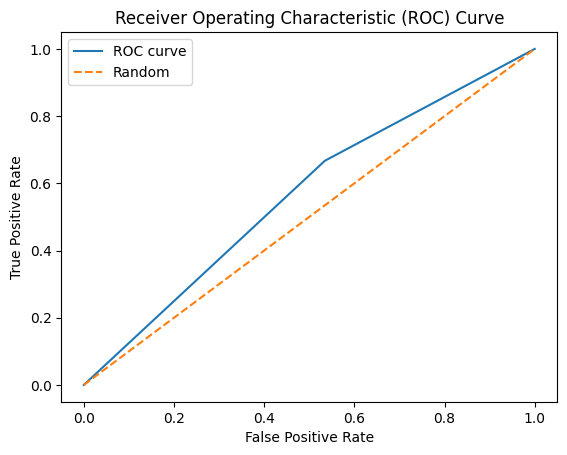

ROC AUC Score: 0.5662604722010662


In [172]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


y_true = predictions['actual']
y_pred = predictions['pred']

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('../results/roc-llama2-similarity.png')
plt.show()

# Compute an approximation of ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)
print(f'ROC AUC Score: {roc_auc}')